In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
from IPython.display import Audio
from scipy import fft
import librosa
import librosa.display
from wavinfo import WavInfoReader
import pandas as pd
import os
import sys
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models,layers
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping


2023-12-11 23:19:55.375880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
def calculate_mfccs(waveform, samplingrate, number_coeffs=128):
    '''
    Caluculate Mel frequency cepstral coefficients.
    Input:
    waveform: array representing the waveform originating from audio file
    samplingrate: sampling rate from audio
    number_coeffs: total number of coefficients to calculate, default is 20
    Output: array of mfccs
    '''
    mfccs = librosa.feature.mfcc(y=waveform, sr=samplingrate,
                                 n_mfcc=number_coeffs)
    return mfccs


def calculate_specbandwidth(waveform, samplingrate, order_p=2):
    '''
    Calculates spectral bandwithd of oder p
    '''
    specbw = librosa.feature.spectral_bandwidth(y=waveform, sr=samplingrate,
                                                p=order_p)

    return specbw


def calculate_spectralcentroid(waveform, samplingrate, nfft=2048, hoplength=512):
    '''
    Calculate spectral centroid
    '''
    specent = librosa.feature.spectral_centroid(y=waveform,
                                                sr=samplingrate, n_fft=nfft,
                                                hop_length=hoplength)

    return specent


def calculate_chroma(waveform, samplingrate, nfft=2048, hoplength=512):
    '''
    Chroma Feature calculation with a hop length of 512 as default

    '''
    chromafeat = librosa.feature.chroma_stft(y=waveform, sr=samplingrate,
                                             n_fft=nfft,
                                             hop_length=hoplength)

    return chromafeat


def calculate_zerocrossrate(waveform, framelength=2048, hoplength=512,):
    '''
    Caluculate Zero crossing rate.

    '''
    zerocr = librosa.feature.zero_crossing_rate(y, frame_length=framelength,
                                                hop_length=hoplength)

    return zerocr


def calculate_spectralroff(waveform, samplingrate, nfft=2048, hoplength=512):
    '''
    Calculate spectral roll off of the waveform
    '''
    specroff = librosa.feature.spectral_rolloff(y=waveform,
                                                sr=samplingrate, n_fft=nfft,
                                                hop_length=hoplength)

    return specroff


In [31]:
def read_audio(audiofile_path, samplingrate=22050, duration=None):
    '''
    Reading in audiofile, returns 1-dimensional array x, sampling rate sr
    '''

    x , sr = librosa.load(audiofile_path, sr=samplingrate, duration=duration)
    return x, sr


def calculate_spectogram(waveform, nfft=2048, hoplength=512):
    '''
    ===  1 Spectogram  ===
    requires 1-dimensional array x(timeseries), sampling rate sr
    returns spectogram, a matplotlib.colormesh object

    '''

    #performing short time- Fourier analysis
    X = librosa.stft(waveform, n_fft=nfft, hop_length=hoplength)

    #amplitudes of given frequency at given time -> spectrogram
    Xdb = librosa.amplitude_to_db(abs(X))

    #plt.figure(figsize=(6, 5), frameon=False)
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') # for demonstration purposes
    
#     spectogram = librosa.display.specshow(Xdb, sr=sr, x_axis=None, y_axis=None) # without axes
    
    return Xdb 

def calculate_melspect(waveform, samplingrate, nfft=2048, hoplength=512):
    
    melspec = librosa.feature.melspectrogram(y=waveform, sr=samplingrate, n_fft=nfft, hop_length=hoplength)
    
    melspec_dB = librosa.power_to_db(melspec)
    
    return melspec_dB


In [32]:
def padding(feat_matrix, size, axis):
    
    padded = librosa.util.pad_center(feat_matrix, size=size, axis=axis)
    
    return padded


def padding_waveforms(waveforms, max_length=132300, axis=0):
    for idx, values in enumerate(waveforms):
        if values.shape[0] < max_length:
            waveforms[idx] = librosa.util.pad_center(waveforms[idx], size=max_length, axis=axis)
    
    return np.array(waveforms)  


def minmaxscaling(matrix):
    max_ = np.max(matrix)
    min_ = np.min(matrix)
    norm = np.array((matrix - min_)/(max_ - min_))
    
    return norm 


In [33]:
def processing_drummers(dataframe):
    df_drummers = dataframe.drop(columns=['drummer', 'id', 'session', 'split', 'midi_filename'])
    df_drummers = df_drummers.dropna()
    df_drummers = df_drummers[df_drummers['beat_type'] == 'beat']
    df_drummers['style_new'] = df_drummers['style'].apply(lambda x: x.split('/')[0]) 
    df_drummers['style'] = df_drummers['style_new']
    
    return df_drummers.drop(columns='style_new')   

def process_genres(drummers_df):
    
    genres = drummers_df['style'].values

    return genres


def process_audiofiles(loc, drummers_df, samplingrate=22050, duration=6):
    
    waveforms_ = drummers_df['audio_filename'].apply(
        lambda x: librosa.load(os.path.join(loc, x), sr=samplingrate, duration=duration)).values
    # genres = drummers_df['style'].values    
    
    waveforms = []
    sr = []
    for values in waveforms_:
        waveforms.append(values[0])
        sr.append(values[1])
    
    waveforms_padded = padding_waveforms(waveforms, max_length=132300, axis=0) 
        
    return waveforms_padded, np.array(sr)


def spectogram_mfccs(waveform, sr):
    mfccs = []
    for idx in range(waveform.shape[0]):
        mfccs.append(calculate_mfccs(waveform[idx], sr[idx], number_coeffs=128)) # mfccs
    
    return np.array(mfccs)


def spectogram_chroma(waveform, sr):
    chroma = []    
    for idx in range(waveform.shape[0]):
        chroma.append(calculate_chroma(waveform[idx], samplingrate=sr[idx]))
    
    return np.array(chroma)
           

def spectogram_stft(waveform):
    spectogram_feat = []
    for idx in range(waveform.shape[0]):
        spectogram_feat.append(calculate_spectogram(waveform[idx]))
    
    return np.array(spectogram_feat)


def spectogram_mel(waveform, sr):
    melspect = [] 
    for idx in range(waveform.shape[0]):
        melspect.append(calculate_melspect(waveform[idx], samplingrate=sr[idx]))
    
    return np.array(melspect)


# def spectrograms(waveform, sr, how='all'):
#     shape_ = waveform.shape[0]
#     if how == 'all':
#         return spectogram_stft(waveform), spe
#         mfccs = []
#         for idx in range(shape_):
#             mfccs.append(calculate_mfccs(waveform[idx], sr[idx], number_coeffs=128)) # mfccs        
    

In [34]:
def reading_audiofile(filename, modus_operandi="no_change", desired_length=6, offset=0.0, pause=1):
    ''' reading in audiofiles
        requires filename (with path)
                modus_operandi:  "no_change" -> reading in audiofile in length, no padding
                                 "silence"-> padding smaller (than desired length) audio files with silence
                                 "repeat" -> padding smaller audio files with repetitive sound (+ pauses)
                desired_length:  in sec, if prespecified length is requested (default value 30)
                                 does not apply if "no_change" modus is chosen
                pause:           in sec, if modus "repeat" is chosen: if a pause between repetions is asked
        returns x (nd-array), sr (sample rate)
    '''

    if modus_operandi=="no_change":
         x , sr = librosa.load(filename, duration=desired_length, offset=0.0)

    if modus_operandi=="repeat":
        # == filling up smaller samples with repeated sounds ==
        x , sr = librosa.load(filename, duration= desired_length, offset=0.0)
        duration = x.shape[0]/sr        # in seconds
        if duration < desired_length:
            pause = int(pause * sr)     # seconds (first number) * sampling rate
            multiplier = int(desired_length // duration)
            single_x=np.append(np.zeros(pause),x)
            for i in range(multiplier):
                x = np.append(x, single_x)
            x=x[0:desired_length*sr]

    if modus_operandi=="silence":
        # == filling up smaller samples with silence ==
        x , sr = librosa.load(filename, duration= desired_length)
        duration = x.shape[0]/22000        # in seconds
        if duration < desired_length:
            filling_zeros = desired_length * sr - x.shape[0]
            x = np.append(x, np.zeros(filling_zeros))
            x=x[0:desired_length*sr]

    return x, sr

In [3]:
pwd = os.path.abspath('.')
loc = os.path.join(pwd, '..', '..', '..' , 'drumbeatid', 'raw_data', 'groove')
# loc_ = '../raw_data/groove/info.csv'
loc

'/Users/HZB/code/vickoru/drumbeatid-2.0/notebooks/../../../drumbeatid/raw_data/groove'

In [4]:
df = pd.read_csv(os.path.join(loc, 'info.csv'))
df.sample(5)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/HZB/code/vickoru/drumbeatid-2.0/notebooks/../../../drumbeatid/raw_data/groove/info.csv'

In [37]:
df_drummers = processing_drummers(df)
df_drummers.head()

,style,bpm,beat_type,time_signature,audio_filename,duration
0,funk,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308
1,soul,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158
2,funk,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218
3,soul,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543
4,soul,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500


In [38]:
df_drummers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 0 to 1133
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   style           444 non-null    object 
 1   bpm             444 non-null    int64  
 2   beat_type       444 non-null    object 
 3   time_signature  444 non-null    object 
 4   audio_filename  444 non-null    object 
 5   duration        444 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 24.3+ KB


In [39]:
df_drummers.isnull().sum()

style             0
bpm               0
beat_type         0
time_signature    0
audio_filename    0
duration          0
dtype: int64

In [40]:
df_drummers.groupby(by='style').count()

,bpm,beat_type,time_signature,audio_filename,duration
style,,,,,
afrobeat,4,4,4,4,4
afrocuban,7,7,7,7,7
blues,4,4,4,4,4
country,2,2,2,2,2
dance,5,5,5,5,5
funk,45,45,45,45,45
gospel,1,1,1,1,1
hiphop,32,32,32,32,32
jazz,50,50,50,50,50


In [41]:
df_train, df_test = train_test_split(df_drummers, test_size=0.2, random_state=7)

In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 224 to 585
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   style           355 non-null    object 
 1   bpm             355 non-null    int64  
 2   beat_type       355 non-null    object 
 3   time_signature  355 non-null    object 
 4   audio_filename  355 non-null    object 
 5   duration        355 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 19.4+ KB


In [43]:
df_train.shape

(355, 6)

In [18]:
# df_new = df_train[['audio_filename', 'style']].groupby(by='style').count() 

In [19]:
# genres_list = list(df_new[df_new['audio_filename'] > 5].index)

In [20]:
# df_train = df_train[df_train['style'].isin(genres_list)]

In [21]:
# df_train.groupby(by='style').count()

In [24]:
def augment_data(waveforms_padded, sr, genres, genre_to_augment, desired_n_of_samples, noise_factor=0.0):
    '''
    required input: waveforms_padded: list of waveforms
                    sr: list of corresponding sampling rates
                    genres: list of genre
                    genre_to_augment: which genre should be augmented?
                    desired_n_of_samples: how many samples of the genre should be there after applying the function=
                    noise_factor: should noise be added? if yes > 0.0


    returns similar to output but just more waveforms, the added ones are generated from the existing ones but
        manipulated in terms of changes of time shift, pitch and speed
    '''
    
    aug_waveforms = []
    aug_sr = []
    aug_genres = []
    
    for i in range(len(genres)):    
        if genres[i] == genre_to_augment:
            aug_waveforms.append(waveforms_padded[i])   # VICTOR <- is it right way to call a single waveform??
            aug_sr.append(sr[i])
            aug_genres.append(genres[i])
            
    n_existing_samples = len(aug_waveforms)
    samples_to_be_created = desired_n_of_samples - n_existing_samples

    for i in range(samples_to_be_created):
        rand_position = random.randint(0,(n_existing_samples-1))
        
        ## choosing random waveform (& associated sr & genre)
        sr_=aug_sr[rand_position]
        genre_=aug_genres[rand_position]
        new_waveform = aug_waveforms[rand_position]

        #adding noise
        #rand_noise = random.uniform(0,0.3)           # added level of noise
        #new_waveform = add_noise(new_waveform, rand_noise)

        #time shift
#         rand_timeshift = random.uniform(0,2)        # amount of timeshift 0 - max (in sec)
#         new_waveform = add_timeshift(waveform=new_waveform, sr=sr_, rand_timeshift=rand_timeshift, shift_direction="both")

        #changing pitch
#         rand_pitch = random.uniform(1,1.5)        # change of pitch
#         new_waveform = change_pitch(waveform=new_waveform, sr=sr_, rand_pitch=rand_pitch)

        #changing speed
#         rand_speed = random.uniform(0.8,1.2)            # change of speed
#         new_waveform = change_speed(waveform=new_waveform, sr=sr_, rand_speed=rand_speed)
        
        #getting waveforms of same length with alternative/better padding function
#         new_waveform = librosa.util.fix_length(new_waveform, size=132300)

        # adding generated waveforms (and sr and genre to lists)
        aug_waveforms.append(new_waveform)
        aug_sr.append(sr_)
        aug_genres.append(genre_)

    #padding waveforms & adding it all together
    aug_waveforms = padding_waveforms(aug_waveforms, max_length=132300, axis=0)

    return aug_waveforms, aug_sr, aug_genres

In [25]:
def add_noise(waveform, noise_factor):
    noise = np.random.randn(len(waveform))
    augmented_waveform = waveform + noise_factor * noise
    # Cast back to same data type
    #augmented_waveform = augmented_waveform.astype(type(data[0]))

    return augmented_waveform


def add_timeshift(waveform, sr, rand_timeshift, shift_direction="both"):
    shift = int(random.uniform(0,sr * rand_timeshift))
    if shift_direction == 'right':
        rand_timeshift = -rand_timeshift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2, 1)
        if direction == 1:
            rand_timeshift = -rand_timeshift
    augmented_data = np.roll(waveform, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0

    return augmented_data


def change_pitch(waveform, sr, rand_pitch):
    return pitch_shift(waveform, sr, rand_pitch)


def change_speed(waveform, sr, rand_speed):
    #return pyrubberband.pyrb.time_stretch(y=waveform, sr=sr, rate=rand_speed)
    return time_stretch(waveform, rate=rand_speed)

In [22]:
# slice_ = int(0.5 * df_train.shape[0])
# df_slice = df_train.iloc[0:slice_]
df_slice = df_train
df_slice.head()

,style,bpm,beat_type,time_signature,audio_filename,duration
224,jazz,125,beat,4-4,drummer1/session1/50_jazz_125_beat_4-4.wav,117.060000
616,soul,86,beat,4-4,drummer5/eval_session/3_soul-groove3_86_beat_4...,44.623520
931,soul,98,beat,4-4,drummer7/session3/159_soul_98_beat_4-4.wav,29.353321
405,punk,128,beat,4-4,drummer1/session2/35_punk_128_beat_4-4.wav,110.610352
1035,neworleans,82,beat,4-4,drummer8/session1/10_neworleans-funk_82_beat_4...,152.240788


In [23]:
waveforms, sr = process_audiofiles(loc, df_slice)
y = process_genres(df_slice)

### Splitting audio with librosa

In [ ]:
def process_audiofiles(loc, drummers_df, samplingrate=22050, desired_length=6):                  #loc mean location = path

    audiofiles = drummers_df['audio_filename'].values
    genre = drummers_df['style'].values
    length = drummers_dr['duration'].values

    waveforms = []
    sr = []
    genres = []

    for i in range(len(audiofiles)):
        filename_ = os.path.join(loc, audiofile[i])
        length_ = length[i]
        genre_ = genre[i]

        if length_ < desired_length:
            x, sr = reading_audiofile(filename, modus_operandi="repeat",
                               desired_length=desired_length, offset=0.0, pause=pause)
            waveforms.append(x)
            sr.append(length_)
            genres.append(genre_)

        elif length_ > desired_length:
            steps=int(length//desired_length)
            for i in range(steps):
                x, sr = reading_audiofile(filename, modus_operandi="no_change",
                             desired_length=desired_length, offset=i*desired_length)

                waveforms.append(x)
                sr.append(length_)
                genres.append(genre_)

            x, sr = reading_audiofile(filename, modus_operandi="repeat",
                                 desired_length=desired_length, offset=steps*desired_length, pause=pause)

            waveforms.append(x)
            sr.append(length_)
            genres.append(genre_)

    waveforms_padded = padding_waveforms(waveforms, max_length=132300, axis=0)

    return waveforms_padded, np.array(sr), genres   # goal same output as victors function 

In [ ]:
def augment_audiofile(filename, desired_length=6, offset=0.0, pause=1):
    ''' reading in audiofiles
         requires filename (with path)
                 modus_operandi:  "no_change" -> reading in audiofile in length, no padding
                                  "silence"-> padding smaller (than desired length) audio files with silence
                                  "repeat" -> padding smaller audio files with repetitive sound (+ pauses)
                 desired_length:  in sec, if prespecified length is requested (default value 30)
                                  does not apply if "no_change" modus is chosen
                 pause:           in sec, if modus "repeat" is chosen: if a pause between repetions is asked
         returns x (nd-array), sr (sample rate)
     '''
            # == filling up smaller samples with repeated sounds ==
    x , sr = librosa.load(filename, duration= desired_length, offset=0.0)
    duration = x.shape[0]/sr        # in seconds
    if duration < desired_length:
        pause = int(pause * sr)     # seconds (first number) * sampling rate
        multiplier = int(desired_length // duration)
        single_x=np.append(np.zeros(pause),x)
        for i in range(multiplier):
            x = np.append(x, single_x)
        
        x=x[0:desired_length*sr]

    return x, sr

In [27]:
style = 'afrobeat'
df_train[df_train['style'] == style]

,style,bpm,beat_type,time_signature,audio_filename,duration
478,afrobeat,94,beat,4-4,drummer1/session3/11_afrobeat_94_beat_4-4.wav,257.856435
1042,afrobeat,90,beat,4-4,drummer8/session1/17_afrobeat_90_beat_4-4.wav,150.822298
1041,afrobeat,90,beat,4-4,drummer8/session1/16_afrobeat_90_beat_4-4.wav,191.965374


In [44]:
filename_ = df_train.loc[478, 'audio_filename']
duration = df_train.loc[478, 'duration']
loc_ = os.path.join(loc, filename_)
loc_

'/Users/HZB/code/vickoru/data-challenges/08-Projects/notebooks/../../../drumbeatid/raw_data/groove/drummer1/session3/11_afrobeat_94_beat_4-4.wav'

In [45]:
reading_audiofile(loc_, 'no_change')[0].shape

(132300,)

In [166]:
y, sr = librosa.load(loc_)

In [167]:
y.shape

(5686085,)

In [168]:
int(duration * sr)

5685734

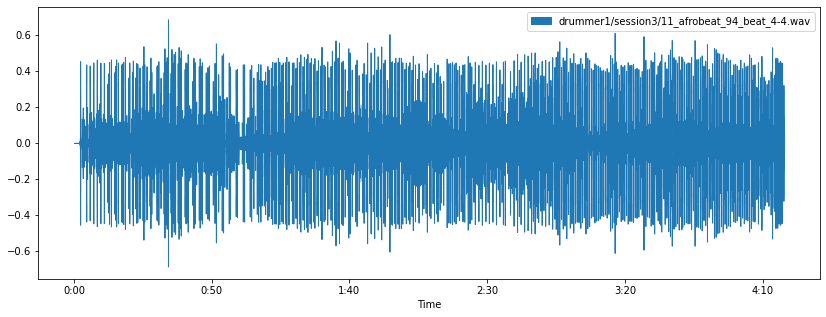

In [169]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, label=filename_)
plt.legend()

In [170]:
nfft = 2048
S = librosa.stft(y, n_fft=nfft, hop_length=nfft//2)
print(S.shape)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
np.max(abs(D))

(1025, 5553)


80.0

In [171]:
librosa.effects.split(y)

array([[  44544,   88576],
       [  89600,  116224],
       [ 117248,  145408],
       [ 145920,  173056],
       [ 174592,  202240],
       [ 203264,  258560],
       [ 259072,  455168],
       [ 456192,  596480],
       [ 596992, 5686085]])

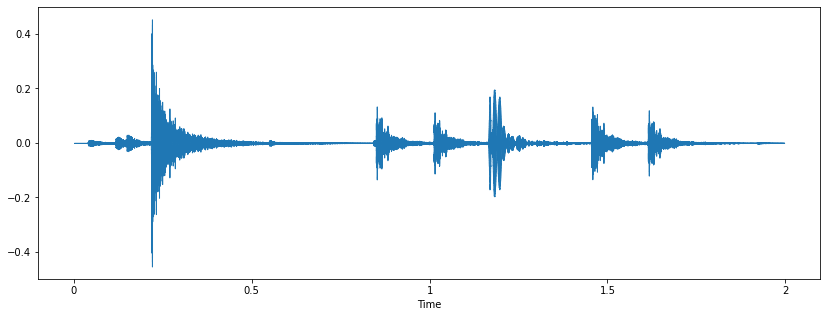

In [172]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y[44544:88576], sr=sr, label=filename_)

In [173]:
tot = int(y.shape[0]/sr)
print(tot)
print(duration)
interval = int(tot/6)
print(interval)
print(interval*6)

257
257.856435
42
252


In [54]:
for idx in range(1, 7):
    print(idx*interval, (idx+1)*interval - 1)

42 83
84 125
126 167
168 209
210 251
252 293


In [57]:
for idx in range(1, 6):
    print(idx*interval*sr, sr*((idx+1)*interval - 1))

926100 1830150
1852200 2756250
2778300 3682350
3704400 4608450
4630500 5534550


In [58]:
aaa = np.zeros((5,2))

In [59]:
aaa[0] = [5,6]

In [60]:
aaa

array([[5., 6.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [90]:
def create_samples2(waveform, sr, duration=6):
    '''
    Split waveform into several subsamples of duration of 6.0 seconds approximately
    '''
    total = int(waveform.shape[0]/sr)
    interval = int(total/duration)
    indexes = np.zeros((duration - 1, 2))
    for idx in range(1, int(duration)):
        indexes[idx-1] = [int(idx*interval*sr), int(sr*((idx+1)*interval - 1))]
    
    return indexes    

In [292]:
def create_samples(waveform, sr, duration=6):
    '''
    Split waveform into several subsamples of duration of 6.0 seconds approximately
    '''
    total_intervals = int(waveform.shape[0]/sr)
    interval = int(total_intervals/duration) + 1
    samples = np.array_split(waveform, interval)    
        
    return np.array(samples)

def process_created_samples(waveform_array, samples, samples_sr, samples_genre, maxlength=132300):
    waveforms = waveform_array[0]
    samplingrates = waveform_array[1]
    genres = waveform_array[2]
    for idx, waveform_idx in enumerate(samples):
        waveform_ = librosa.util.fix_length(waveform_idx, size=maxlength)
        waveforms = np.vstack((waveforms, waveform_))
        samplingrates = np.append(samplingrates, samples_sr)
        genres.append(samples_genre)
    
    return waveforms, samplingrates, genres
    
    

In [282]:
filename_ = df_train.loc[478, 'audio_filename']
duration = df_train.loc[478, 'duration']
genre = df_train.loc[478, 'style']
loc_ = os.path.join(loc, filename_)
loc_

'/Users/HZB/code/vickoru/data-challenges/08-Projects/notebooks/../../../drumbeatid/raw_data/groove/drummer1/session3/11_afrobeat_94_beat_4-4.wav'

In [283]:
y, sr = librosa.load(loc_)

In [284]:
samples = create_samples(y, sr)

/var/folders/jw/d43bpk916bz864ddr7_d7nqh0000gp/T/ipykernel_87035/2101366394.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(samples)


In [285]:
len(samples)

43

In [298]:
waveforms = []
sr_s = []
genres_s = []
maxlength=132300
waveforms.append(librosa.util.fix_length(samples[0], size=maxlength))
waveforms.append(librosa.util.fix_length(samples[1], size=maxlength))
sr_s.append(sr)
sr_s.append(sr)
genres_s.append('afro')
genres_s.append('afro')
waveforms = np.array(waveforms)
sr_s = np.array(sr_s)

In [ ]:
process_created_samples(waveforms, )

In [267]:
sssr = []
maxlength=132300
waveform_ = librosa.util.fix_length(samples[0], size=maxlength)

In [268]:
waveform_.shape

(132300,)

In [269]:
waveforms.shape

(2, 132300)

In [270]:
np.vstack((waveforms, waveform_))

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00093308, -0.00091162, -0.00084308, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [277]:
sr_s.shape

(2,)

In [274]:
sr

22050

In [280]:
np.append(sr_s, sr)

array([22050, 22050, 22050])

In [293]:
new_y, new_sr, new_genres = process_created_samples([waveforms, sr_s, genres], samples, sr, genre)

In [294]:
new_y.shape

(45, 132300)

In [295]:
new_sr.shape

(45,)

In [297]:
len(new_genres)

174

In [231]:
y_duration, sr_duration = librosa.load(loc_, duration=6)

In [232]:
    duration = 6
    total = int(y.shape[0]/sr)
    interval = int(total/duration)
    indexes = np.zeros((duration - 1, 2))


In [248]:
maxlength = y_duration.shape[0]

In [234]:
interval

42

In [235]:
kk = np.array_split(y, interval + 1)

In [236]:
len(kk)

43

In [237]:
librosa.util.fix_length(kk[0], size=maxlength).shape

(132300,)

In [238]:
kk[0].shape

(132235,)

In [239]:
total = int(y.shape[0]/y_duration.shape[0])
total

42

In [240]:
kk = np.array_split(y, total + 1)

In [241]:
len(kk)

43

In [242]:
kk[-1].shape

(132234,)

In [243]:
y, sr = librosa.load(loc_, duration=6)

In [180]:
y.shape

(132300,)

In [203]:
samples = create_samples(y, sr)
print(samples.shape)

(8,)


/var/folders/jw/d43bpk916bz864ddr7_d7nqh0000gp/T/ipykernel_87035/82760675.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(samples)


In [204]:
samples[0].shape

(710761,)

In [255]:
waveforms = []
sr_s = []
genres = []
waveforms.append(kk[0])
waveforms.append(kk[1])
sr_s.append(sr)
sr_s.append(sr)
genres.append('afro')
genres.append('afro')
waveforms = np.array(waveforms)
sr_s = np.array(sr_s)

In [256]:
waveforms.shape

(2, 132235)

In [257]:
sr_s

array([22050, 22050])

In [160]:
np.vstack((waveforms, samples[0])).shape

(3, 135383)

In [161]:
samples.shape

(42,)

In [162]:
for i, val in enumerate(samples[0:10]):
    waveforms = np.vstack((waveforms, val))
    print(waveforms.shape)


(3, 135383)
(4, 135383)
(5, 135383)
(6, 135383)
(7, 135383)
(8, 135383)
(9, 135383)
(10, 135383)
(11, 135383)
(12, 135383)


In [122]:
samples.shape

AttributeError: 'list' object has no attribute 'shape'

In [62]:
aaa = create_samples(y, sr)

In [63]:
aaa

array([[ 926100., 1830150.],
       [1852200., 2756250.],
       [2778300., 3682350.],
       [3704400., 4608450.],
       [4630500., 5534550.]])

In [77]:
    waveform = y
    duration=6
    total = int(waveform.shape[0]/sr)
    interval = int(total/duration)
    indexes = np.zeros((duration - 1, 2))

In [78]:
print(interval)

42


In [ ]:
interval* 

In [87]:
kk = np.array_split(y, interval+1)

In [88]:
length = []
for val in kk:
    length.append([val.shape])

In [89]:
length

[[(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132235,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)],
 [(132234,)]]

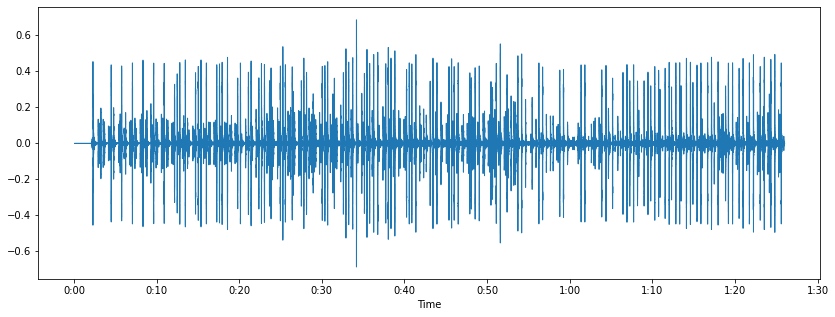

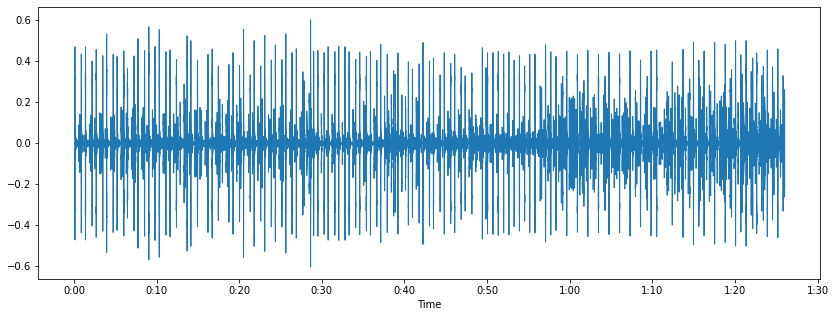

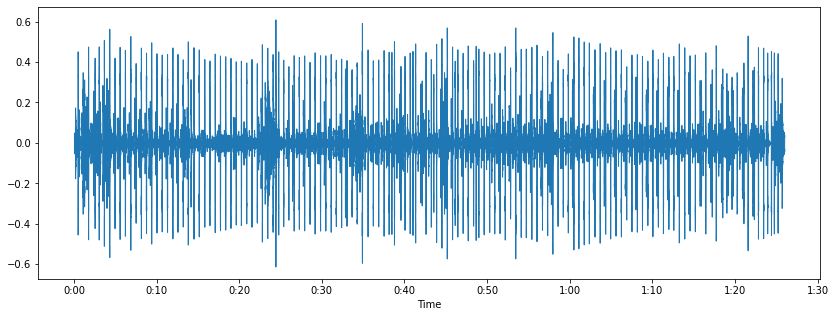

In [75]:
for value in kk:
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(value, sr=sr)
    plt.show()